# Heat Transfer II
February 26th, 2025

Data analysis & Comsol post-processing by Alex Quemel, Rahil Shaik, Sneha Kancharla, and Ethan Mibu

### Pre-processing

In [1426]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [1427]:
data = {
    'Flow Rate (SCFM)': [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    'Thermistor #': [4, 5, 6, 4, 5, 6, 4, 5, 6, 4, 5, 6],
    'Temperature 1 (°C)': [115.8, 113.6, 111.7, 113.3, 110.8, 108.4, 112.0, 109.1, 106.3, 109.0, 106.8, 104.1],
    'Temperature 2 (°C)': [116.2, 114.8, 112.7, 116.0, 113.9, 111.1, 115.7, 113.2, 110.1, 115.1, 112.0, 108.5],
    'Temperature 3 (°C)': [None, None, None, 115.8, 113.4, 111.0, 114.7, 111.8, 108.7, None, None, None],\
    'Q_in (W)': [35.50, 35.50, 35.50, 42.33, 42.33, 42.33, 44.83, 44.83, 44.83, 45.13, 45.13, 45.13],
}

In [1428]:
df = pd.DataFrame(data)
df["Avg Temp (°C)"] = df[["Temperature 1 (°C)", "Temperature 2 (°C)", "Temperature 3 (°C)"]].mean(axis=1)
df["Avg Temp (K)"] = df["Avg Temp (°C)"] + 273.15

In [1429]:
def get_positions(thermistor_number):
    if thermistor_number == 6:
        return .0125
    elif thermistor_number == 5:
        return .0125 + .0254
    elif thermistor_number == 4:
        return .0125 + .0254 + .0254
    else:
        return None
    
df["positions (m)"] = df["Thermistor #"].apply(get_positions)

## Experimental Data Analysis

### Question 2
$$ \textbf{From an appropriate plot of your thermistor data, obtain the convective heat-transfer coefficient at the end of the rod, h, for all air flow rates. }$$ 
$$ \textbf{Fit your data utilizing the method you determine most appropriate to extrapolate the temperature and its gradient at the brass-rod face.}$$


Our goal should be to plot temperature readings across the position and extrapolate the line to the ends of the rod. We will use this line to find a linear expression for T(z)

In [1430]:
df

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m)
0,1,4,115.8,116.2,NaN,35.50,116.000000,389.150000,0.0633
1,1,5,113.6,114.8,NaN,35.50,114.200000,387.350000,0.0379
2,1,6,111.7,112.7,NaN,35.50,112.200000,385.350000,0.0125
3,2,4,113.3,116.0,115.8,42.33,115.033333,388.183333,0.0633
4,2,5,110.8,113.9,113.4,42.33,112.700000,385.850000,0.0379
5,2,6,108.4,111.1,111.0,42.33,110.166667,383.316667,0.0125
6,3,4,112.0,115.7,114.7,44.83,114.133333,387.283333,0.0633
7,3,5,109.1,113.2,111.8,44.83,111.366667,384.516667,0.0379
8,3,6,106.3,110.1,108.7,44.83,108.366667,381.516667,0.0125
9,4,4,109.0,115.1,NaN,45.13,112.050000,385.200000,0.0633


In [1431]:
df_1 = df[df["Flow Rate (SCFM)"] == 1]
df_2 = df[df["Flow Rate (SCFM)"] == 2]
df_3 = df[df["Flow Rate (SCFM)"] == 3]
df_4 = df[df["Flow Rate (SCFM)"] == 4]

In [1432]:
df_1

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m)
0,1,4,115.8,116.2,NaN,35.5,116.0,389.15,0.0633
1,1,5,113.6,114.8,NaN,35.5,114.2,387.35,0.0379
2,1,6,111.7,112.7,NaN,35.5,112.2,385.35,0.0125


Text(0.5, 1.0, 'Temperature readings down brass rod')

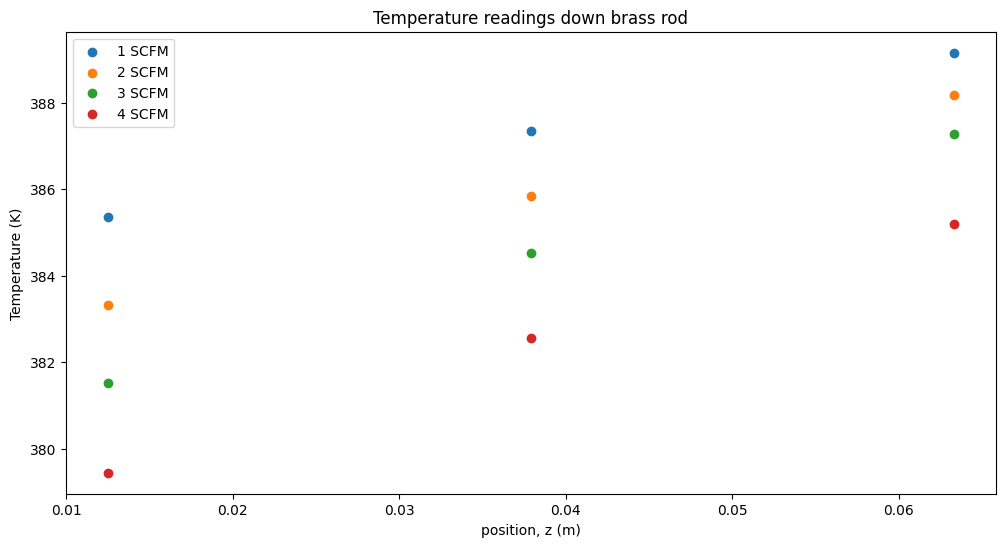

In [1433]:
plt.figure(figsize=(12,6))
plt.scatter(df_1["positions (m)"], df_1["Avg Temp (K)"], label = "1 SCFM")
plt.scatter(df_2["positions (m)"], df_2["Avg Temp (K)"], label = "2 SCFM")
plt.scatter(df_3["positions (m)"], df_3["Avg Temp (K)"], label = "3 SCFM")
plt.scatter(df_4["positions (m)"], df_4["Avg Temp (K)"], label = "4 SCFM")
plt.legend()
plt.xlabel("position, z (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature readings down brass rod")

Now, that we have this plot, lets find an expression that defines the temperature across Z. Theoretically, at z = 0, the temperature should be the same as the heater, any discrepancy will be defined as a bias.


We need to use this temperature gradient to solve for convective heat transfer coefficient. Because radial heat flux dominates convective heat transfer, we should compute radial heat flux using an energy balance.

We start with an energy balance:
$$ Q_{in} = Q_{axial} + Q_{radial} + Q_{losses} $$

Then, we solve for Q_losses using our bias value from the heater input to the brass rod as:

$$ Q_{losses} = Q_{in} \times \frac{T_{heater} - T_{brass,heater}}{T_{heater} - T_{air}}$$

$$ Q_{radial} = Q_{in} - Q_{axial} - Q_{losses} $$

Then, we get q_radial by combining Fourier's law with Newton's law of cooling:

$$ q_{radial} = \frac{Q_{radial}}{A_{rod \ face}} = h(T_{surface} - T_{air})$$

Isolating h:

$$h_{conv} = \frac{Q_{radial}}{ A_{rod \ face}(T_{surface}-T_{air})}$$

Which gives convective heat transfer coefficient using radial heat flux. 

First, we must calculate Q_axial by finding an expression for T(z) down the rod

In [1434]:
rod_length = 0.081 # m
rod_diam = .025 # m
heater_input = 133 + 273.15 # K
k_brass = 120 # W/mK
k_air = 0.025 # W/mK
k_nylon = 0.365 # W/mK
T_air = 20 + 273.15 # K
T_air_jet = 20.6 + 273.15 # K
k_nylon = 0.25 # W/mK
nylon_rad = 0.0254 # m
jet_rad = 0.03182 # m

In [1435]:
slope_1, intercept_1, _, _, _ = stats.linregress(df_1["positions (m)"], df_1["Avg Temp (K)"])

slope_2, intercept_2, _, _, _ = stats.linregress(df_2["positions (m)"], df_2["Avg Temp (K)"])

slope_3, intercept_3, _, _, _ = stats.linregress(df_3["positions (m)"], df_3["Avg Temp (K)"])

slope_4, intercept_4, _, _, _ = stats.linregress(df_4["positions (m)"], df_4["Avg Temp (K)"])

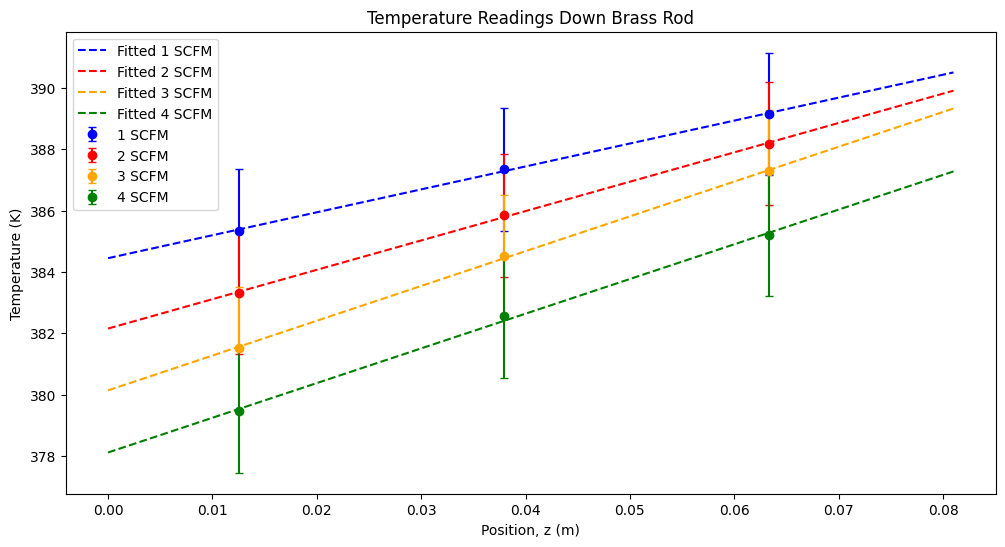

In [1436]:
plt.figure(figsize=(12,6))

error_1 = np.full_like(df_1["Avg Temp (K)"], 2)  # Replace with actual std deviation
error_2 = np.full_like(df_2["Avg Temp (K)"], 2)  
error_3 = np.full_like(df_3["Avg Temp (K)"], 2)  
error_4 = np.full_like(df_4["Avg Temp (K)"], 2)  

# Raw data with error bars
plt.errorbar(df_1["positions (m)"], df_1["Avg Temp (K)"], yerr=error_1, fmt='o', label="1 SCFM", capsize=3, color = "blue")
plt.errorbar(df_2["positions (m)"], df_2["Avg Temp (K)"], yerr=error_2, fmt='o', label="2 SCFM", capsize=3, color = "red")
plt.errorbar(df_3["positions (m)"], df_3["Avg Temp (K)"], yerr=error_3, fmt='o', label="3 SCFM", capsize=3, color = "orange")
plt.errorbar(df_4["positions (m)"], df_4["Avg Temp (K)"], yerr=error_4, fmt='o', label="4 SCFM", capsize=3, color = "green")

plt.xlabel("Position, z (m)")
plt.ylabel("Temperature (K)")
plt.title("Temperature Readings Down Brass Rod")

positions = np.linspace(0, rod_length, 50)

# Fit lines
plt.plot(positions, [pos * slope_1 + intercept_1 for pos in positions], label="Fitted 1 SCFM", linestyle="--", color = "blue")
plt.plot(positions, [pos * slope_2 + intercept_2 for pos in positions], label="Fitted 2 SCFM", linestyle="--", color = "red")
plt.plot(positions, [pos * slope_3 + intercept_3 for pos in positions], label="Fitted 3 SCFM", linestyle="--", color = "orange")
plt.plot(positions, [pos * slope_4 + intercept_4 for pos in positions], label="Fitted 4 SCFM", linestyle="--", color = "green")

# Heater input temperature line
# plt.axhline(y=133 + 273.15, linestyle="--", label="Heater Input Temperature", color="black")

plt.legend()
plt.show()


The end of each plot line should approach 406 K heating input temperature but it is a bit off, so there is heat loss at the heater-brass interface. Let's compute that loss.

In [1437]:
bias_1 = heater_input - (slope_1 * rod_length + intercept_1)
bias_2 = heater_input - (slope_2 * rod_length + intercept_2)
bias_3 = heater_input - (slope_3 * rod_length + intercept_3)
bias_4 = heater_input - (slope_4 * rod_length + intercept_4)

In [1438]:
print("Bias for 1 SCFM:", bias_1, "K")
print("Bias for 2 SCFM:", bias_2, "K")
print("Bias for 3 SCFM:", bias_3, "K")
print("Bias for 4 SCFM:", bias_4, "K")

Bias for 1 SCFM: 15.642650918635127 K
Bias for 2 SCFM: 16.237664041994776 K
Bias for 3 SCFM: 16.818525809273865 K
Bias for 4 SCFM: 18.871555118110166 K


Now we can use Newton's Law of Cooling:

$$q_{axial} = h_{axial} (T_{surface}-T_{air})$$


and Fourier's Law:

$$q = -k\nabla T $$

which simplifies to:

$$q_{axial} = -k \frac{dT}{dz} $$

Giving: 
$$h_{axial} = \frac{-k_{air}(\frac{dT}{dx})}{T_{surface}-T_{air}}$$

Using this bias and the slope were able to extract from the linear fit line, we can define expressions for dT/dz for each flow rate, enabling us to compute each h value

In [1439]:
def h_1(T):
    return (k_brass * slope_1)  / (T - T_air)

def h_2(T):
    return (k_brass * slope_2)  / (T - T_air)

def h_3(T):
    return (k_brass * slope_3)  / (T - T_air)

def h_4(T):
    return (k_brass * slope_4)  / (T - T_air)

In [1440]:
df_1["h_axial (W/m^2 K)"] = df_1["Avg Temp (K)"].apply(h_1)
df_2["h_axial (W/m^2 K)"] = df_2["Avg Temp (K)"].apply(h_2)
df_3["h_axial (W/m^2 K)"] = df_3["Avg Temp (K)"].apply(h_3)
df_4["h_axial (W/m^2 K)"] = df_4["Avg Temp (K)"].apply(h_4)

In [1441]:
df_2

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m),h_axial (W/m^2 K)
3,2,4,113.3,116.0,115.8,42.33,115.033333,388.183333,0.0633,120.968744
4,2,5,110.8,113.9,113.4,42.33,112.700000,385.850000,0.0379,124.013625
5,2,6,108.4,111.1,111.0,42.33,110.166667,383.316667,0.0125,127.497926


Using this h_axial value, let's get axial heat flux

In [1442]:
def T_1(z):
    return slope_1 * z + intercept_1

def T_2(z):
    return slope_2 * z + intercept_2

def T_3(z):
    return slope_3 * z + intercept_3

def T_4(z):
    return slope_4 * z + intercept_4

In [1443]:
df_1["q_axial (W/m^2)"] = df_1["h_axial (W/m^2 K)"] * (df_1["Avg Temp (K)"] - T_air_jet)
df_2["q_axial (W/m^2)"] = df_2["h_axial (W/m^2 K)"] * (df_2["Avg Temp (K)"] - T_air_jet)
df_3["q_axial (W/m^2)"] = df_3["h_axial (W/m^2 K)"] * (df_3["Avg Temp (K)"] - T_air_jet)
df_4["q_axial (W/m^2)"] = df_4["h_axial (W/m^2 K)"] * (df_4["Avg Temp (K)"] - T_air_jet)

In [1444]:
df_4["q_axial (W/m^2)"]

9     13494.142605
10    13491.518258
11    13488.243720
Name: q_axial (W/m^2), dtype: float64

### Via extrapolation, the temperature at the brass rod faces are below as:

In [1445]:
print("1 SCFM tempearature at impinging jet brass rod face", intercept_1, "K")
print("1 SCFM  gradient at impinging jet brass rod face", slope_1, "K/m")

print("2 SCFM tempearature at impinging jet brass rod face", intercept_2, "K")
print("2 SCFM  gradient at impinging jet brass rod face", slope_2, "K/m")

print("3 SCFM tempearature at impinging jet brass rod face", intercept_3, "K")
print("3 SCFM  gradient at impinging jet brass rod face", slope_3, "K/m")

print("4 SCFM tempearature at impinging jet brass rod face", intercept_4, "K")
print("4 SCFM  gradient at impinging jet brass rod face", slope_4, "K/m")


1 SCFM tempearature at impinging jet brass rod face 384.44829396325457 K
1 SCFM  gradient at impinging jet brass rod face 74.80314960629944 K/m
2 SCFM tempearature at impinging jet brass rod face 382.15249343832016 K
2 SCFM  gradient at impinging jet brass rod face 95.80052493438336 K/m
3 SCFM tempearature at impinging jet brass rod face 380.1365923009624 K
3 SCFM  gradient at impinging jet brass rod face 113.51706036745378 K/m
4 SCFM tempearature at impinging jet brass rod face 378.11013779527565 K
4 SCFM  gradient at impinging jet brass rod face 113.18897637795277 K/m


Now that we have Q_axial and Q_in, we need Q_losses using the expression from above

In [1446]:
T_brass_heater_1 = slope_1 * rod_length + intercept_1
T_brass_heater_2 = slope_2 * rod_length + intercept_2
T_brass_heater_3 = slope_3 * rod_length + intercept_3
T_brass_heater_4 = slope_4 * rod_length + intercept_4

In [1447]:
df_1["Q_losses (W)"] = df_1["Q_in (W)"] * (heater_input - T_brass_heater_1) / (heater_input - T_air)
df_2["Q_losses (W)"] = df_2["Q_in (W)"] * (heater_input - T_brass_heater_2) / (heater_input - T_air)
df_3["Q_losses (W)"] = df_3["Q_in (W)"] * (heater_input - T_brass_heater_3) / (heater_input - T_air)
df_4["Q_losses (W)"] = df_4["Q_in (W)"] * (heater_input - T_brass_heater_4) / (heater_input - T_air)

In [1448]:
df_1

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m),h_axial (W/m^2 K),q_axial (W/m^2),Q_losses (W)
0,1,4,115.8,116.2,NaN,35.5,116.0,389.15,0.0633,93.503937,8920.275591,4.914284
1,1,5,113.6,114.8,NaN,35.5,114.2,387.35,0.0379,95.290636,8919.203571,4.914284
2,1,6,111.7,112.7,NaN,35.5,112.2,385.35,0.0125,97.357678,8917.963346,4.914284


Let's compute Q_radial using the energy balance

In [1449]:
df_1["Q_axial (W)"] = df_1["q_axial (W/m^2)"] * (np.pi * (rod_diam/2)**2)
df_2["Q_axial (W)"] = df_2["q_axial (W/m^2)"] * (np.pi * (rod_diam/2)**2)
df_3["Q_axial (W)"] = df_3["q_axial (W/m^2)"] * (np.pi * (rod_diam/2)**2)
df_4["Q_axial (W)"] = df_4["q_axial (W/m^2)"] * (np.pi * (rod_diam/2)**2)

In [1450]:
df_1["Q_rad (W)"] = df_1["Q_in (W)"] - df_1["Q_axial (W)"] - df_1["Q_losses (W)"]
df_2["Q_rad (W)"] = df_2["Q_in (W)"] - df_2["Q_axial (W)"] - df_2["Q_losses (W)"]
df_3["Q_rad (W)"] = df_3["Q_in (W)"] - df_3["Q_axial (W)"] - df_3["Q_losses (W)"]
df_4["Q_rad (W)"] = df_4["Q_in (W)"] - df_4["Q_axial (W)"] - df_4["Q_losses (W)"]

Combining Fourier's law and Newton's Law of Cooling gives convective heat transfer coefficient

In [1451]:
df_1["h_conv (W/m^2 K)"] = df_1["Q_rad (W)"] / ( (np.pi * (jet_rad)**2) * (heater_input - T_brass_heater_1))
df_2["h_conv (W/m^2 K)"] = df_2["Q_rad (W)"] / ( (np.pi * (jet_rad)**2) * (heater_input - T_brass_heater_2))
df_3["h_conv (W/m^2 K)"] = df_3["Q_rad (W)"] / ( (np.pi * (jet_rad)**2) * (heater_input - T_brass_heater_3))
df_4["h_conv (W/m^2 K)"] = df_4["Q_rad (W)"] / ( (np.pi * (jet_rad)**2) * (heater_input - T_brass_heater_4))

In [1452]:
df_2

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m),h_axial (W/m^2 K),q_axial (W/m^2),Q_losses (W),Q_axial (W),Q_rad (W),h_conv (W/m^2 K)
3,2,4,113.3,116.0,115.8,42.33,115.033333,388.183333,0.0633,120.968744,11423.481746,6.082658,5.607488,30.639854,593.216079
4,2,5,110.8,113.9,113.4,42.33,112.700000,385.850000,0.0379,124.013625,11421.654817,6.082658,5.606592,30.640751,593.233442
5,2,6,108.4,111.1,111.0,42.33,110.166667,383.316667,0.0125,127.497926,11419.564237,6.082658,5.605565,30.641777,593.253310


### Question 3
$$\textbf{Calculate the axial heat flux leaving the brass-rod face.}$$

In [1453]:
df_1

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m),h_axial (W/m^2 K),q_axial (W/m^2),Q_losses (W),Q_axial (W),Q_rad (W),h_conv (W/m^2 K)
0,1,4,115.8,116.2,NaN,35.5,116.0,389.15,0.0633,93.503937,8920.275591,4.914284,4.378730,26.206986,526.691727
1,1,5,113.6,114.8,NaN,35.5,114.2,387.35,0.0379,95.290636,8919.203571,4.914284,4.378204,26.207512,526.702303
2,1,6,111.7,112.7,NaN,35.5,112.2,385.35,0.0125,97.357678,8917.963346,4.914284,4.377595,26.208121,526.714538


In [1454]:
df_1["q_rad (W / m^2)"] = df_1["Q_rad (W)"] / (2 * np.pi * (rod_diam / 2) * rod_length)
df_2["q_rad (W / m^2)"] = df_2["Q_rad (W)"] / (2 * np.pi * (rod_diam / 2) * rod_length)
df_3["q_rad (W / m^2)"] = df_3["Q_rad (W)"] / (2 * np.pi * (rod_diam / 2) * rod_length)
df_4["q_rad (W / m^2)"] = df_4["Q_rad (W)"] / (2 * np.pi * (rod_diam / 2) * rod_length)

$$\textbf {Estimate the overall radial heat-transfer coefficient, 
U, between the brass rod and the surrounding air. }$$
$$ \textbf{ You must consider what heat-transfer resistances exist between the rod and the air.}$$

The radial heat transfer resistances between the rod and the air is given by conduction through the nylon into the air and convection at the face. Let's first find the heat transfer resistance values in the radial direction.

$$ R_{\text{cond}} = \frac{\ln \left( \frac{r_i}{r_{i-1}} \right)}{2\pi k_i L}$$


$$
R_{T,\text{conv}} = \frac{1}{h_i 2\pi r_i L}
$$

$$
U = \frac{1}{\left(\sum R_T\right) A_{\text{surface}}}
$$


In [1455]:
R_brass_cond = np.log((rod_diam / 2) / (rod_diam / 2)) / (2 * np.pi * k_brass * rod_length)
R_nylon_cond = np.log( (nylon_rad / 2) / (rod_diam / 2)) / (2 * np.pi * k_nylon * rod_length)

df_1["R_conv (K/W)"] = 1 / (df_1["h_conv (W/m^2 K)"] * 2 * np.pi * (rod_diam / 2) * rod_length)
df_2["R_conv (K/W)"] = 1 / (df_2["h_conv (W/m^2 K)"] * 2 * np.pi * (rod_diam / 2) * rod_length)
df_3["R_conv (K/W)"] = 1 / (df_3["h_conv (W/m^2 K)"] * 2 * np.pi * (rod_diam / 2) * rod_length)
df_4["R_conv (K/W)"] = 1 / (df_4["h_conv (W/m^2 K)"] * 2 * np.pi * (rod_diam / 2) * rod_length)

$$ \frac{1}{U} = R_{brass} + R_{nylon} + R_{conv} $$

In [1456]:
df_1["U (W / m^2 K)"] = 1 / ((df_1["R_conv (K/W)"] + R_brass_cond + R_nylon_cond) * 2 * np.pi * (rod_diam / 2) * rod_length)
df_2["U (W / m^2 K)"] = 1 / ((df_2["R_conv (K/W)"] + R_brass_cond + R_nylon_cond) * 2 * np.pi * (rod_diam / 2) * rod_length)
df_3["U (W / m^2 K)"] = 1 / ((df_3["R_conv (K/W)"] + R_brass_cond + R_nylon_cond) * 2 * np.pi * (rod_diam / 2) * rod_length)
df_4["U (W / m^2 K)"] = 1 / ((df_4["R_conv (K/W)"] + R_brass_cond + R_nylon_cond) * 2 * np.pi * (rod_diam / 2) * rod_length)

In [1457]:
df_2

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m),h_axial (W/m^2 K),q_axial (W/m^2),Q_losses (W),Q_axial (W),Q_rad (W),h_conv (W/m^2 K),q_rad (W / m^2),R_conv (K/W),U (W / m^2 K)
3,2,4,113.3,116.0,115.8,42.33,115.033333,388.183333,0.0633,120.968744,11423.481746,6.082658,5.607488,30.639854,593.216079,4816.280683,0.264979,403.324385
4,2,5,110.8,113.9,113.4,42.33,112.700000,385.850000,0.0379,124.013625,11421.654817,6.082658,5.606592,30.640751,593.233442,4816.421649,0.264972,403.332411
5,2,6,108.4,111.1,111.0,42.33,110.166667,383.316667,0.0125,127.497926,11419.564237,6.082658,5.605565,30.641777,593.253310,4816.582960,0.264963,403.341595


### Question 4
$$ \textbf{Compare the values of the heat-transfer coefficient to values from texts, handbooks, or
references of appropriate heat-transfer correlations.}$$
$$ \textbf{Use (at least) one correlation to
predict the heat transfer coefficient under the experimental conditions (i.e. dimensionless
quantities)} $$

In [1458]:
df_1

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m),h_axial (W/m^2 K),q_axial (W/m^2),Q_losses (W),Q_axial (W),Q_rad (W),h_conv (W/m^2 K),q_rad (W / m^2),R_conv (K/W),U (W / m^2 K)
0,1,4,115.8,116.2,NaN,35.5,116.0,389.15,0.0633,93.503937,8920.275591,4.914284,4.378730,26.206986,526.691727,4119.477864,0.298448,371.428075
1,1,5,113.6,114.8,NaN,35.5,114.2,387.35,0.0379,95.290636,8919.203571,4.914284,4.378204,26.207512,526.702303,4119.560581,0.298442,371.433334
2,1,6,111.7,112.7,NaN,35.5,112.2,385.35,0.0125,97.357678,8917.963346,4.914284,4.377595,26.208121,526.714538,4119.656278,0.298435,371.439419


In [1459]:
radial_length = rod_diam / 2
kin_viscosity_air = 1.51 * 10**-5 #m^2/s
rho_air = 1.203 # kg/m^3
c_p = 1005 # J/kg·K
alpha = k_air / (rho_air*c_p)

In [1460]:
def scfm_to_mps(scfm, area=(np.pi * (jet_rad / 2)**2)):
    flow_rate = scfm * 0.0283168 / 60  # 1 SCFM = 0.0283168 m^3/min, convert to m^3/s
    return flow_rate / area

velocities = [] # appending this list for later use
for df in [df_1, df_2, df_3, df_4]:
    velocities.append(scfm_to_mps(df["Flow Rate (SCFM)"].iloc[0]))
    df["velocity (m/s)"] = scfm_to_mps(df["Flow Rate (SCFM)"] )

Computing reynolds numbers at each air velocity

In [1461]:
def Reynolds(velocity, diam, kinematic_viscosity):
    return velocity * diam / kinematic_viscosity

In [1462]:
Reynolds_vals_1 = Reynolds(df_1["velocity (m/s)"], jet_rad, kin_viscosity_air)
Reynolds_vals_2 = Reynolds(df_2["velocity (m/s)"], jet_rad, kin_viscosity_air)
Reynolds_vals_3 = Reynolds(df_3["velocity (m/s)"], jet_rad, kin_viscosity_air)
Reynolds_vals_4 = Reynolds(df_4["velocity (m/s)"], jet_rad, kin_viscosity_air)

In [1463]:
def Prandtl(momentum_diffusivity, thermal_diffusivity):
    return momentum_diffusivity / thermal_diffusivity

In [1464]:
Prandtl_val_1 = Prandtl(kin_viscosity_air, alpha)
Prandtl_val_2 = Prandtl(kin_viscosity_air, alpha)
Prandtl_val_3 = Prandtl(kin_viscosity_air, alpha)
Prandtl_val_4 = Prandtl(kin_viscosity_air, alpha)

In [1465]:
def Nus_correl(Re,Pr):
    return 1.54 * Re**(1/2) * Pr**(1/3)

In [1466]:
Nu_L_1 = Nus_correl(Reynolds_vals_1, Prandtl_val_1)
Nu_L_2 = Nus_correl(Reynolds_vals_2, Prandtl_val_2)
Nu_L_3 = Nus_correl(Reynolds_vals_3, Prandtl_val_3)
Nu_L_4 = Nus_correl(Reynolds_vals_4, Prandtl_val_4)

In [1467]:
h_1 = Nu_L_1 * k_air / radial_length
h_2 = Nu_L_2 * k_air / radial_length
h_3 = Nu_L_3 * k_air / radial_length
h_4 = Nu_L_4 * k_air / radial_length

In [1468]:
df_4

,Flow Rate (SCFM),Thermistor #,Temperature 1 (°C),Temperature 2 (°C),Temperature 3 (°C),Q_in (W),Avg Temp (°C),Avg Temp (K),positions (m),h_axial (W/m^2 K),q_axial (W/m^2),Q_losses (W),Q_axial (W),Q_rad (W),h_conv (W/m^2 K),q_rad (W / m^2),R_conv (K/W),U (W / m^2 K),velocity (m/s)
9,4,4,109.0,115.1,NaN,45.13,112.05,385.20,0.0633,147.557601,13494.142605,7.536932,6.623922,30.969147,515.906885,4868.042227,0.304687,366.031978,2.373901
10,4,5,106.8,112.0,NaN,45.13,109.40,382.55,0.0379,151.931512,13491.518258,7.536932,6.622634,30.970435,515.928345,4868.244722,0.304674,366.042781,2.373901
11,4,6,104.1,108.5,NaN,45.13,106.30,379.45,0.0125,157.389075,13488.243720,7.536932,6.621026,30.972042,515.955122,4868.497387,0.304658,366.056259,2.373901


In [1469]:
print("At velocities 0.593475, 1.186951, 1.780426, 2.373901, respectively")
h_1.iloc[0], h_2.iloc[0], h_3.iloc[0], h_4.iloc[0]

At velocities 0.593475, 1.186951, 1.780426, 2.373901, respectively


(np.float64(98.08514052086377),
 np.float64(138.71333599187636),
 np.float64(169.88844684966887),
 np.float64(196.17028104172755))

### Question 5
$$ \textbf{Determine the scaling of the experimental heat-transfer coefficient with jet velocity or,
equivalently, the scaling of the Nusselt number with the Reynolds number.} $$ 
$$ \textbf{Plot the data
in a way that the scaling exponent can be determined graphically.} $$

The experimental heat transfer coefficient is given by the sum of the axial and radial heat transfer coefficient

In [1470]:
df_1["h_radial (W/m^2 K)"] = df_1["q_rad (W / m^2)"] / (df_1["Avg Temp (K)"] - T_air_jet)
df_2["h_radial (W/m^2 K)"] = df_2["q_rad (W / m^2)"] / (df_2["Avg Temp (K)"] - T_air_jet)
df_3["h_radial (W/m^2 K)"] = df_3["q_rad (W / m^2)"] / (df_3["Avg Temp (K)"] - T_air_jet)
df_4["h_radial (W/m^2 K)"] = df_4["q_rad (W / m^2)"] / (df_4["Avg Temp (K)"] - T_air_jet)

In [1471]:
for df in [df_1, df_2, df_3, df_4]:
    df["h (W/m^2 K)"] = df["h_axial (W/m^2 K)"] + df["h_radial (W/m^2 K)"]

In [1472]:
h_exp_values = [df_1["h (W/m^2 K)"].mean(), df_2["h (W/m^2 K)"].mean(), df_3["h (W/m^2 K)"].mean(), df_4["h (W/m^2 K)"].mean()]

In [1591]:
df_1["h (W/m^2 K)"].mean()

np.float64(139.4400581529736)

In [1474]:
h_values = [h_1.iloc[0], h_2.iloc[0], h_3.iloc[0], h_4.iloc[0]]

log_h_values = [np.log10(h) for h in h_values]
log_h_exp_values = [np.log10(h) for h in h_exp_values]
log_velocities = [np.log10(v) for v in velocities]

slope, intercept, r_value, p_value, std_err = stats.linregress(log_velocities, log_h_exp_values)

In [1475]:
h_exp_values

[np.float64(139.4400581529736),
 np.float64(176.51809555213245),
 np.float64(203.98008979596742),
 np.float64(207.24703447217647)]

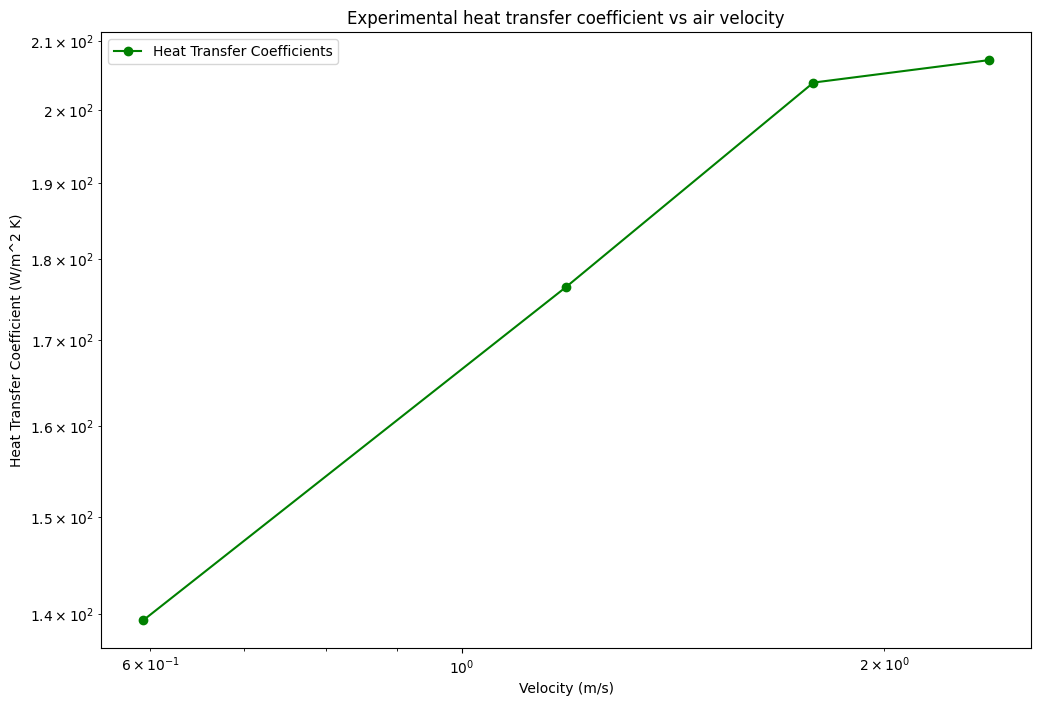

In [1590]:
plt.figure(figsize=(12, 8))
plt.plot(velocities, h_exp_values, marker = 'o', label = 'Heat Transfer Coefficients', color = 'green')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Velocity (m/s)")
plt.ylabel("Heat Transfer Coefficient (W/m^2 K)")
plt.title("Experimental heat transfer coefficient vs air velocity")
plt.legend()
plt.show()

In [1477]:
print(f"Slope: {slope:.4f}")
print(f"Standard Error of Slope: {std_err:.4f}")


Slope: 0.3009
Standard Error of Slope: 0.0364


## COMSOL Data Analysis & Report Tasks

#### Reading in data

In [1478]:
df_sim_1 = pd.read_csv("data/1scfm_temp_data.csv")
df_sim_2 = pd.read_csv('data/2scfm_temp_data.csv')
df_sim_3 = pd.read_csv('data/3scfm_temp_data.csv')
df_sim_4 = pd.read_csv('data/4scfm_temp_data.csv')

In [1479]:
df_sim_1.head()

,r,z,T (K)
0,0.001092,-0.008912,294.143026
1,0.000000,-0.010000,293.600000
2,0.001590,-0.010000,293.600000
3,0.000000,-0.008002,295.324943
4,0.002418,-0.008780,293.624283


### Question 2

$$ \textbf{Show how energy flows through the system and attempt to close an energy balance with the
COMSOL simulation results} $$

$$ \textbf{What percentage of the input heat flow leaves the rod axially
through the rod face and what percentage leaves the rod radially? } $$

$$ \textbf{How do these results compare to those obtained experimentally?} $$

Now, we can close our energy balance on these values from the comsol analysis and determine Q_losses

$$ Q_{in} = Q_{radial} + Q_{axial} + Q_{losses} $$


In [1528]:
q_radial = [2623.6, 2648.8, 2676.2, 2716.7 ]# W/m^2
q_axial = [59008, 57360, 55425, 52377 ] # W/m^2

In [1549]:
flows = [1,2 ,3 ,4] # SCFM
Q_radial = [q * (2 * np.pi * (rod_diam/2) * rod_length) for q in q_radial]
Q_axial = [q * (np.pi * (rod_diam/2) ** 2) for q in q_axial]
Q_in = [47.33, 42.33, 44.83, 45.13] # from raw data

In [1543]:
print(Q_axial)

[28.965484266097896, 28.156524157798522, 27.206683253939733, 25.710499752667594]


In [1544]:
Q_losses = []
for i, Q in enumerate(Q_in):
    Q_losses.append(Q - Q_axial[i] - Q_radial[i])

print(Q_losses)

[1.6738936998367855, -2.67746166497653, 0.59806797049783, 2.1366016042674403]


In [1546]:
Q_radial_props = np.array(Q_radial) / np.array(Q_in)
Q_axial_props = np.array(Q_axial) / np.array(Q_in)
Q_loss_props = np.array(Q_losses) / np.array(Q_in)

In [1565]:
print(Q_axial_props)

[0.61198995 0.66516712 0.60688564 0.56969864]


In [1566]:
print(Q_radial_props)

[0.35264361 0.39808499 0.37977356 0.38295809]


Text(0.5, 0, 'flow rate (SCFM)')

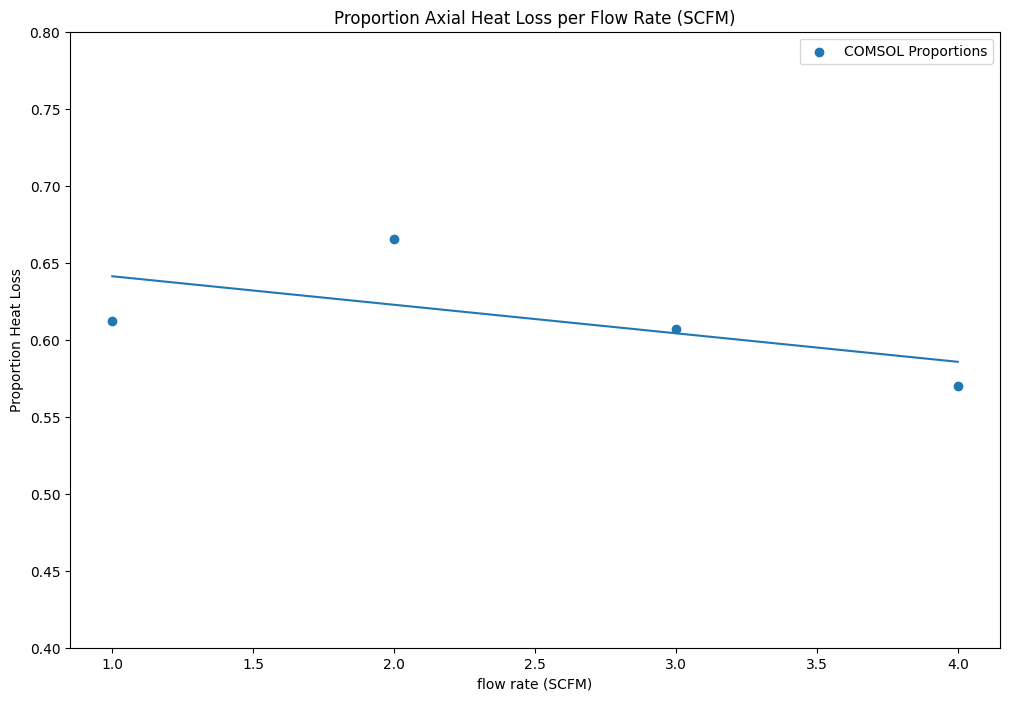

In [1572]:
plt.figure(figsize=(12,8))
slope, intercept, _, _, _ = stats.linregress(flows, Q_axial_props)
plt.scatter(flows, Q_axial_props, label="COMSOL Proportions")
plt.plot(flows, [intercept + slope * flow  for flow in flows])
plt.ylim(0.4, 0.8)
plt.legend()
plt.title("Proportion Axial Heat Loss per Flow Rate (SCFM)")
plt.ylabel("Proportion Heat Loss")
plt.xlabel("flow rate (SCFM)")


### Question 3
$$ \textbf{Plot the axial temperatures along the rod along the centerline (i.e., T(0, z>0)) and compare them to your experimental values.} $$

The first step is to get all the data along the center line on the rod as r == 0 and z > 0

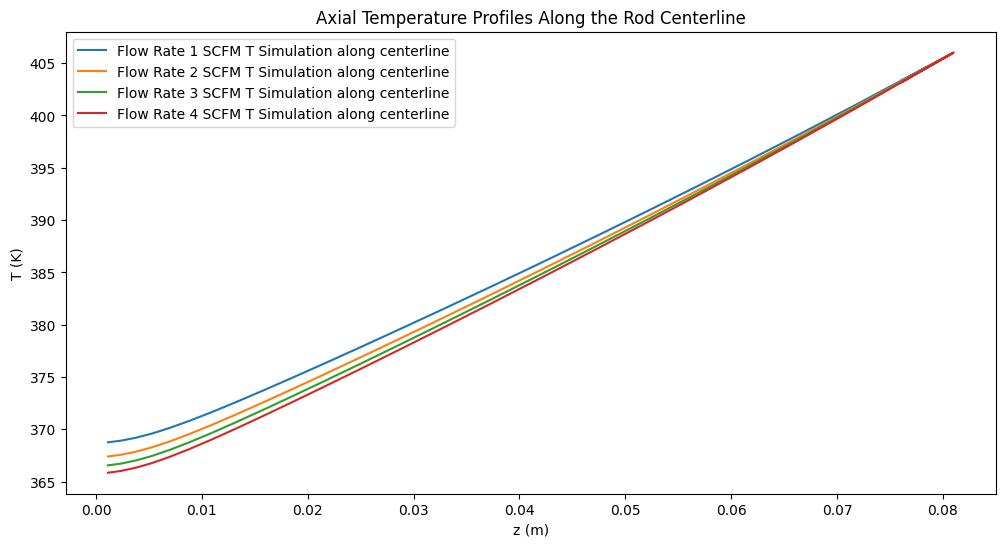

In [1491]:
plt.figure(figsize=(12, 6))
plt.plot(df_sim_1.query("r == 0 and z > 0")['z'], df_sim_1.query("r == 0 and z > 0")['T (K)'], label = 'Flow Rate 1 SCFM T Simulation along centerline')
plt.plot(df_sim_2.query("r == 0 and z > 0")['z'], df_sim_2.query("r == 0 and z > 0")['T (K)'], label = 'Flow Rate 2 SCFM T Simulation along centerline')
plt.plot(df_sim_3.query("r == 0 and z > 0")['z'], df_sim_3.query("r == 0 and z > 0")['T (K)'], label = 'Flow Rate 3 SCFM T Simulation along centerline')
plt.plot(df_sim_4.query("r == 0 and z > 0")['z'], df_sim_4.query("r == 0 and z > 0")['T (K)'], label = 'Flow Rate 4 SCFM T Simulation along centerline')
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title('Axial Temperature Profiles Along the Rod Centerline')
plt.legend()
plt.show()

$$ \textbf{Comment on any differences. Can you explain the differences? Discuss the shape} $$

Do in report

### Question 4
$$ \textbf{Plot the centerline temperature profile in the air as a function of distance from the brass-rod face (i.e., T(0, z<0)) at varying Vin.}$$

In [1492]:
dist_rod_face_1 = df_sim_1.query("r == 0 and z < 0")
dist_rod_face_2 = df_sim_2.query("r == 0 and z < 0")
dist_rod_face_3 = df_sim_3.query("r == 0 and z < 0")
dist_rod_face_4 = df_sim_4.query("r == 0 and z < 0")

In [1493]:
dist_rod_face_1 = dist_rod_face_1.sort_values(by = 'z')
dist_rod_face_2 = dist_rod_face_2.sort_values(by = 'z')
dist_rod_face_3 = dist_rod_face_3.sort_values(by = 'z')
dist_rod_face_4 = dist_rod_face_4.sort_values(by = 'z')

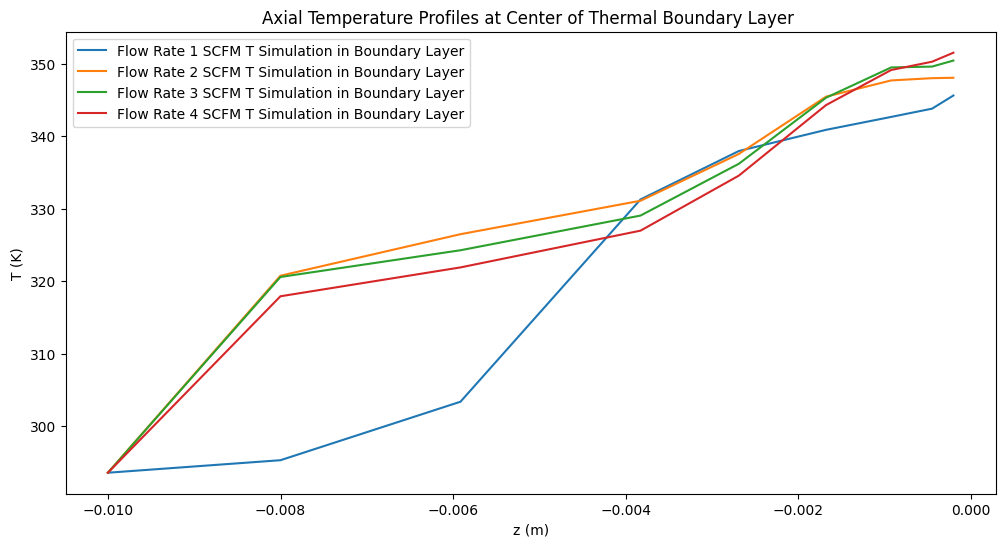

In [1494]:
plt.figure(figsize=(12, 6))
plt.plot(dist_rod_face_1['z'], dist_rod_face_1['T (K)'], label = 'Flow Rate 1 SCFM T Simulation in Boundary Layer')
plt.plot(dist_rod_face_2['z'], dist_rod_face_2['T (K)'], label = 'Flow Rate 2 SCFM T Simulation in Boundary Layer')
plt.plot(dist_rod_face_3['z'], dist_rod_face_3['T (K)'], label = 'Flow Rate 3 SCFM T Simulation in Boundary Layer')
plt.plot(dist_rod_face_4['z'], dist_rod_face_4['T (K)'], label = 'Flow Rate 4 SCFM T Simulation in Boundary Layer')
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title('Axial Temperature Profiles at Center of Thermal Boundary Layer ')
plt.legend()
plt.show()

$$ \textbf{Utilize these plots to show how the temperature boundary-
layer thickness, δT, varies with Vin. Does the quantitative scaling of δT with Vin match the
expectations from theory? } $$
$$ \textbf{Depending on the boundary-layer thickness, you may need to
decrease the mesh size to its finest settings to obtain accurate estimations of boundary-layer
thickness. } $$

$$ {\textbf{Is the finest predefined mesh size fine enough? What is the uncertainty in these
measurements for δT?}}

Do this in report

### Question 5

$$ \textbf{Compute and plot the heat transfer coefficient h vs. distance r along the rod face for each
value of the inlet velocity.} $$
$$ \textbf{You must use the definition of h in terms of the heat flux at the
interface between the brass surface and the air} $$

Since we're looking specifically at along the rod face and the heat flux at the interface between the brass surface and the air, let's extract z == 0 rows from the dataframe 

In [1495]:
rod_face_1 = df_sim_1.query("z == 0")
rod_face_2 = df_sim_2.query("z == 0")
rod_face_3 = df_sim_3.query("z == 0")
rod_face_4 = df_sim_4.query("z == 0")

In [1496]:
rod_face_1["dT_dr"] = np.gradient(rod_face_1["r"], rod_face_1["T (K)"])
rod_face_2["dT_dr"] = np.gradient(rod_face_2["r"], rod_face_2["T (K)"])
rod_face_3["dT_dr"] = np.gradient(rod_face_3["r"], rod_face_3["T (K)"])
rod_face_4["dT_dr"] = np.gradient(rod_face_4["r"], rod_face_4["T (K)"])

We need to use different k values based on whether the radius is greater or less than 0.0125

In [1497]:
rod_face_1["h_radial"] = rod_face_1.apply(lambda row: -k_brass * row["dT_dr"] if row["r"] <= 0.0125 else -k_nylon * row["dT_dr"], axis=1)
rod_face_2["h_radial"] = rod_face_2.apply(lambda row: -k_brass * row["dT_dr"] if row["r"] <= 0.0125 else -k_nylon * row["dT_dr"], axis=1)
rod_face_3["h_radial"] = rod_face_3.apply(lambda row: -k_brass * row["dT_dr"] if row["r"] <= 0.0125 else -k_nylon * row["dT_dr"], axis=1)
rod_face_4["h_radial"] = rod_face_4.apply(lambda row: -k_brass * row["dT_dr"] if row["r"] <= 0.0125 else -k_nylon * row["dT_dr"], axis=1)

In [1498]:
rod_face_1 = rod_face_1.sort_values(by=['r'])
rod_face_2 = rod_face_2.sort_values(by=['r'])
rod_face_3 = rod_face_3.sort_values(by=['r'])
rod_face_4 = rod_face_4.sort_values(by=['r'])

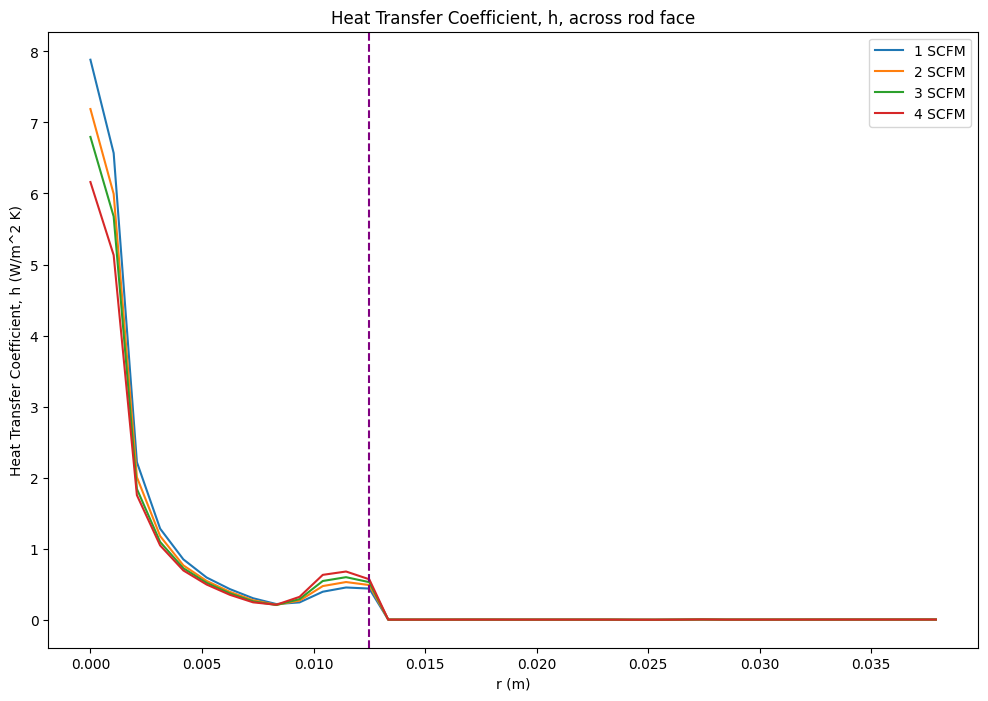

In [1499]:
plt.figure(figsize=(12, 8))
plt.plot(rod_face_1['r'], rod_face_1["h_radial"], label="1 SCFM")
plt.plot(rod_face_2['r'], rod_face_2["h_radial"], label="2 SCFM")
plt.plot(rod_face_3['r'], rod_face_3["h_radial"], label="3 SCFM")
plt.plot(rod_face_4['r'], rod_face_4["h_radial"], label = "4 SCFM")
plt.legend()
plt.title("Heat Transfer Coefficient, h, across rod face")
plt.xlabel("r (m)")
plt.ylabel("Heat Transfer Coefficient, h (W/m^2 K)")
plt.axvline(x=.0125, label="brass rod radius",linestyle="--", color="purple")

$$ \textbf{What is the expected scaling here and how do your data follow it?} $$

Since we know

$$ Nu \propto Re^{0.5}$$

Then our theoretical scaling for h is:

$$ h(r) \propto r^{-0.5} $$

Let's check if this scaling holds for the brass rod regime

In [1500]:
eps = 1e-10

for df in [rod_face_1, rod_face_2, rod_face_3, rod_face_4]:
    df["log r"] = np.log10(df["r"].where(df["r"] > eps, eps))
    df["log h_radial"] = np.log10(df["h_radial"].where(df["h_radial"] > eps, eps))


In [1501]:
rod_face_1.head()

,r,z,T (K),dT_dr,h_radial,log r,log h_radial
137,0.000000,0.0,368.686417,-0.065694,7.883323,-10.000000,0.896709
138,0.001042,0.0,368.670561,-0.054742,6.569074,-2.982271,0.817504
140,0.002083,0.0,368.623044,-0.018475,2.217005,-2.681241,0.345767
142,0.003125,0.0,368.538779,-0.010674,1.280895,-2.505150,0.107514
144,0.004167,0.0,368.410144,-0.007069,0.848262,-2.380211,-0.071470


In [1502]:
slope_1, _, _, _, std_error_1 = stats.linregress(rod_face_1["log r"], rod_face_1["log h_radial"])
slope_2, _, _, _, std_error_2 = stats.linregress(rod_face_2["log r"], rod_face_2["log h_radial"])
slope_3, _, _, _, std_error_3 = stats.linregress(rod_face_3["log r"], rod_face_3["log h_radial"])
slope_4, _, _, _, std_error_4 = stats.linregress(rod_face_4["log r"], rod_face_4["log h_radial"])

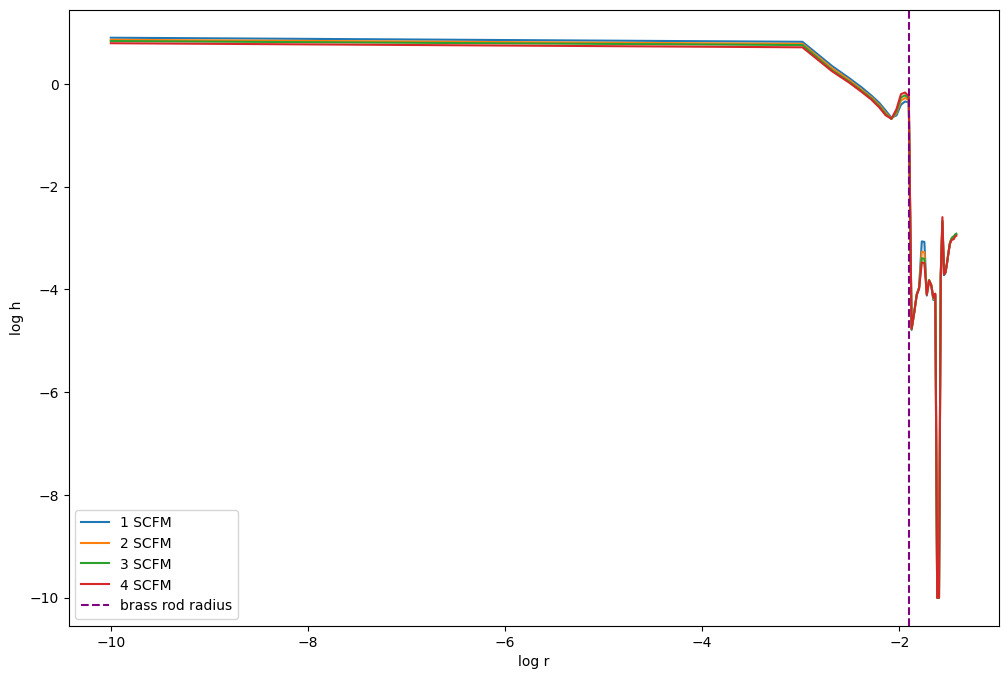

In [1503]:
plt.figure(figsize=(12, 8))
plt.plot(rod_face_1['log r'], rod_face_1["log h_radial"], label="1 SCFM")
plt.plot(rod_face_2['log r'], rod_face_2["log h_radial"], label="2 SCFM")
plt.plot(rod_face_3['log r'], rod_face_3["log h_radial"], label="3 SCFM")
plt.plot(rod_face_4['log r'], rod_face_4["log h_radial"], label = "4 SCFM")
plt.axvline(x = np.log10(radial_length) , label="brass rod radius", linestyle="--", color="purple")
plt.xlabel("log r")
plt.ylabel("log h")
plt.legend()

In [1504]:
print("1 SCFM scaling factor ", slope_1, "std err", std_error_1)

1 SCFM scaling factor  -0.7167771265473138 std err 0.27159625022588124


So we have scaling of:

$$ h(r) \propto r^{-0.712 ± 0.27} $$

Which is steeper than the theoretical scaling

### Question 6

$$ \textbf{Now compute the spatially-averaged value of h over the rod face and plot it vs. the inlet
velocity Vin. } $$

$$ \textbf{Note that the spatially averaged value of h involves the integral of the heat flux
over the entire heat transfer area divided by the total area. } $$

$$ \textbf{COMSOL has post processing that
allows one to take the integral of a flux along a specified surface area. } $$

$$ \textbf{Plot this value of h in a
way in which you can verify the expected scaling quantitatively and comment.} $$

We have the following h spatially averaged values from Comsol for each air velocity:

In [1505]:
h_spatial = [29.1715, 37.3915, 40.554, 44.652] 

For the theoretical scaling:

$$ Nu \propto Re^{0.5}$$

We should have the scaling between h and V_in as:
$$ h_{avg} \propto V_{in} ^ {0.5} $$

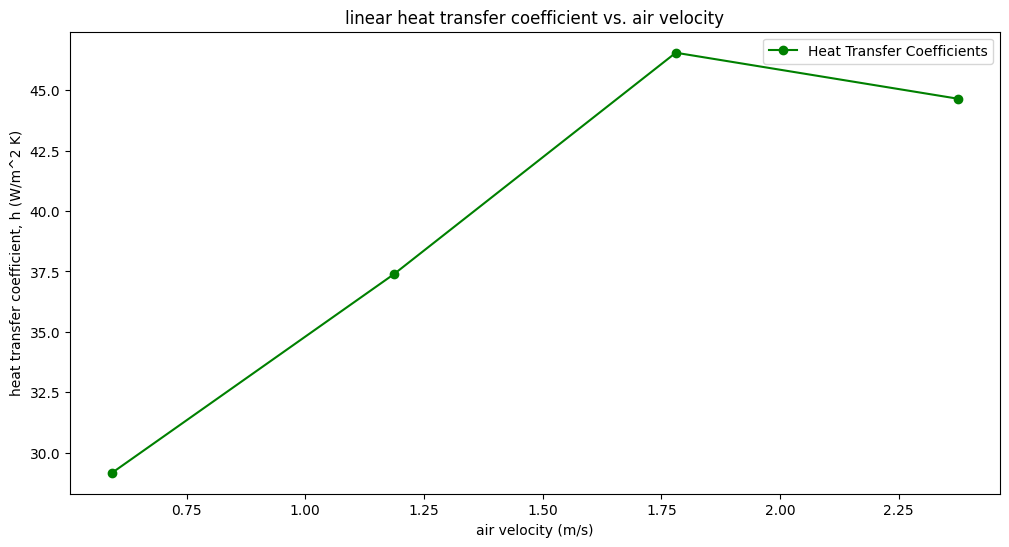

In [1506]:
plt.figure(figsize=(12, 6))
plt.plot(velocities, h_spatial, marker = 'o', label = 'Heat Transfer Coefficients', color = 'green')
plt.ylabel('heat transfer coefficient, h (W/m^2 K)')
plt.xlabel("air velocity (m/s)")
plt.title("linear heat transfer coefficient vs. air velocity")
plt.legend()

Now plotting this on a log scale

In [1507]:
log_h_spatial = [np.log10(h) for h in h_spatial]

slope, _, _, _, std_err = stats.linregress(log_velocities, log_h_spatial)

scaling factor 0.34025129727574455 std err 0.06835266503491454


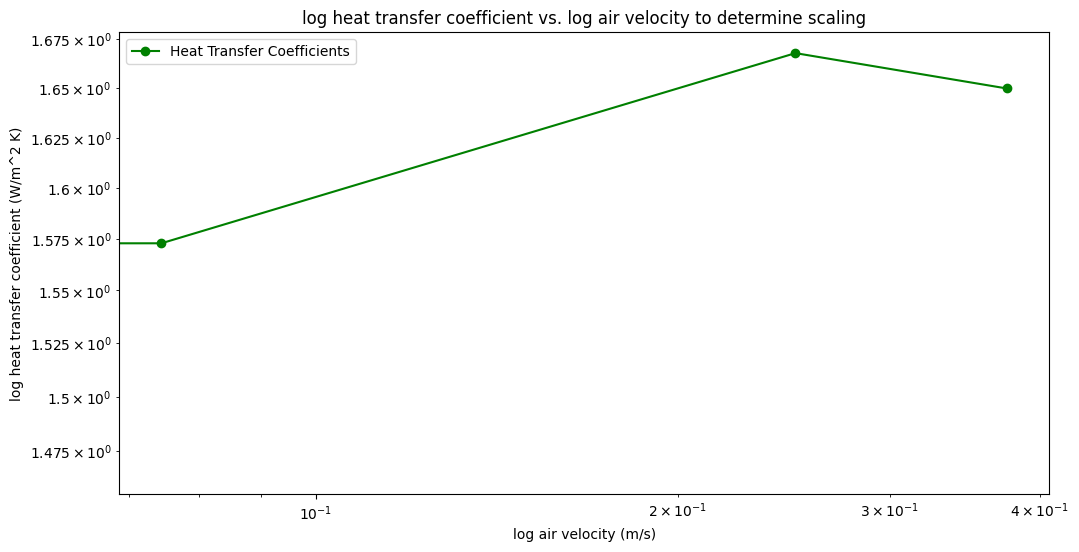

In [1508]:
plt.figure(figsize=(12, 6))
plt.plot(log_velocities, log_h_spatial, marker = 'o', label = 'Heat Transfer Coefficients', color = 'green')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("log air velocity (m/s)")
plt.ylabel("log heat transfer coefficient (W/m^2 K)")
plt.title("log heat transfer coefficient vs. log air velocity to determine scaling")

print("scaling factor", slope, "std err", std_err)

So we have scaling of:

$$ h \propto V_{in} ^{0.30 ± 0.022} $$ 

## Question 7 

$$ \textbf{Locate in the literature (see references below) an appropriate correlation for the Nusselt
number dependence on Reynolds and Prandtl numbers for this laminar impinging-jet flow} $$

From the literature, we can see a correlation of:

$$ Nu = 1.54 Re^{\frac{1}{2}} Pr^{\frac{1}{3}} $$

Giving:

$$ C_1 = 1.54, C_2 = \frac{1}{2}, C_3 = \frac{1}{3} $$

Isolating for C2 here gives:

$$ ln(Nu) = C2 \times ln(Re) + \frac{1}{3}ln(Pr) + ln(1.54) $$

$$ C2 = \frac{ln(Nu) - \frac{1}{3}ln(Pr)  - ln(1.54)}{ln(Re)}  $$



In [1509]:
cp_air = 1006 # J/kg·K
kin_viscosity_air = 1.56e-5 #m^2/s
rho_air = 1.205 # kg/m^3
alpha = k_air / (rho_air*c_p)

def Reynolds_list(velocities, diam, kinematic_viscosity):
    return [velocity * diam / kinematic_viscosity for velocity in velocities]

def Nus_correl_list(Reynolds,Pr):
    return [1.54 * Re**(1/2) * Pr**(1/3) for Re in Reynolds]

In [1510]:
Nu_values = [(h / k_air) * (jet_rad * 2) for h in h_spatial]
Re_values = Reynolds_list(velocities, jet_rad*2, kin_viscosity_air)
Pr_values = Prandtl(kin_viscosity_air, alpha)

In [1511]:
C2 = (np.log(Nu_values) - (1/3) * np.log(Pr_values) - np.log(1.54)) / np.log(Re_values)

In [1512]:
C2

array([0.50939069, 0.49703593, 0.49901992, 0.47883386])

Looks like our C2 values are very close to the theoretical value of 0.5

Now let's get h using these correlations and compare to expected, starting with re-computing expected values of h

In [1513]:
Reynolds_vals_exp = Reynolds_list(velocities, jet_rad*2, kin_viscosity_air)
Prandtl_val_exp = Prandtl(kin_viscosity_air, alpha)
Nuss_vals_exp = Nus_correl_list(Reynolds_vals_exp, Prandtl_val_exp)

h=[]
for i, Nu in enumerate(Nuss_vals_exp):
    h.append((Nu * k_air)/ (jet_rad * 2 ))


In [1514]:
print("spatially averaged heat transfer coeffficient from correlations ", [float(value) for value in h])
print("spatially averaged heat transfer coeffficient from comsol simulation ", h_spatial)


spatially averaged heat transfer coeffficient from correlations  [27.11318827402649, 38.34383857630343, 46.9614196457946, 54.22637654805298]
spatially averaged heat transfer coeffficient from comsol simulation  [29.1715, 37.3915, 46.554, 44.652]


### Question 8

$$ \textbf{Stagnant-film theory estimates h as the ratio of gas thermal conductivity to boundary layer
thickness, h = k/δT.} $$
$$ \textbf{Compare h from the simulation to this estimate for each value of inlet
velocity and comment.} $$

In order to determine h through the stagnant-film theory, we must first calculate boundary layer thickness which we will compute as the distance from the brass rod face that has reached 99% of the bulk temperature.

We start with finding bulk temperature as 99% of the difference between surface T and bulk temperature

In [1515]:
surface_T_1 = df_sim_1.query("r == 0 and z == 0")['T (K)']
surface_T_2 = df_sim_2.query("r == 0 and z == 0")['T (K)']
surface_T_3 = df_sim_3.query("r == 0 and z == 0")['T (K)']
surface_T_4 = df_sim_4.query("r == 0 and z == 0")['T (K)']

In [1516]:
bulk_T_diff_1 = surface_T_1 - T_air_jet
bulk_T_diff_2 = surface_T_2 - T_air_jet
bulk_T_diff_3 = surface_T_3 - T_air_jet
bulk_T_diff_4 = surface_T_4 - T_air_jet

In [1517]:
df_sim_1["T_drop"] = df_sim_1["T (K)"] - T_air_jet
df_sim_2["T_drop"] = df_sim_2["T (K)"] - T_air_jet
df_sim_3["T_drop"] = df_sim_3["T (K)"] - T_air_jet
df_sim_4["T_drop"] = df_sim_4["T (K)"] - T_air_jet

In [1518]:
BL_1 = df_sim_1.query("z < 0 and T_drop >= 0.01 * T_drop.max() and r > 0")
BL_2 = df_sim_2.query("z < 0 and T_drop >= 0.01 * T_drop.max() and r > 0")
BL_3 = df_sim_3.query("z < 0 and T_drop >= 0.01 * T_drop.max() and r > 0")
BL_4 = df_sim_4.query("z < 0 and T_drop >= 0.01 * T_drop.max() and r > 0")

In [1519]:
BL_1 = BL_1.sort_values(by = 'z' )
BL_2 = BL_2.sort_values(by = 'z')
BL_3 = BL_3.sort_values(by = 'z')
BL_4 = BL_4.sort_values(by = 'z')

Handling r = 0 before doing log operation

In [1520]:
BL_1["log abs(z)"] = np.log10(abs(BL_1["z"]))
BL_2["log abs(z)"] = np.log10(abs(BL_2["z"]))
BL_3["log abs(z)"] = np.log10(abs(BL_3["z"]))
BL_4["log abs(z)"] = np.log10(abs(BL_4["z"]))

BL_1["log T_drop"] = np.log10(BL_1["T_drop"])
BL_2["log T_drop"] = np.log10(BL_2["T_drop"])
BL_3["log T_drop"] = np.log10(BL_3["T_drop"])
BL_4["log T_drop"] = np.log10(BL_4["T_drop"])

BL_1["log r"] = np.log(BL_1["r"])
BL_2["log r"] = np.log(BL_2["r"])
BL_3["log r"] = np.log(BL_3["r"])
BL_4["log r"] = np.log(BL_4["r"])

In [1521]:
BL_1["r/d"] = BL_1["r"] / jet_rad*2
BL_2["r/d"] = BL_2["r"] / jet_rad*2
BL_3["r/d"] = BL_3["r"] / jet_rad*2
BL_4["r/d"] = BL_4["r"] / jet_rad*2

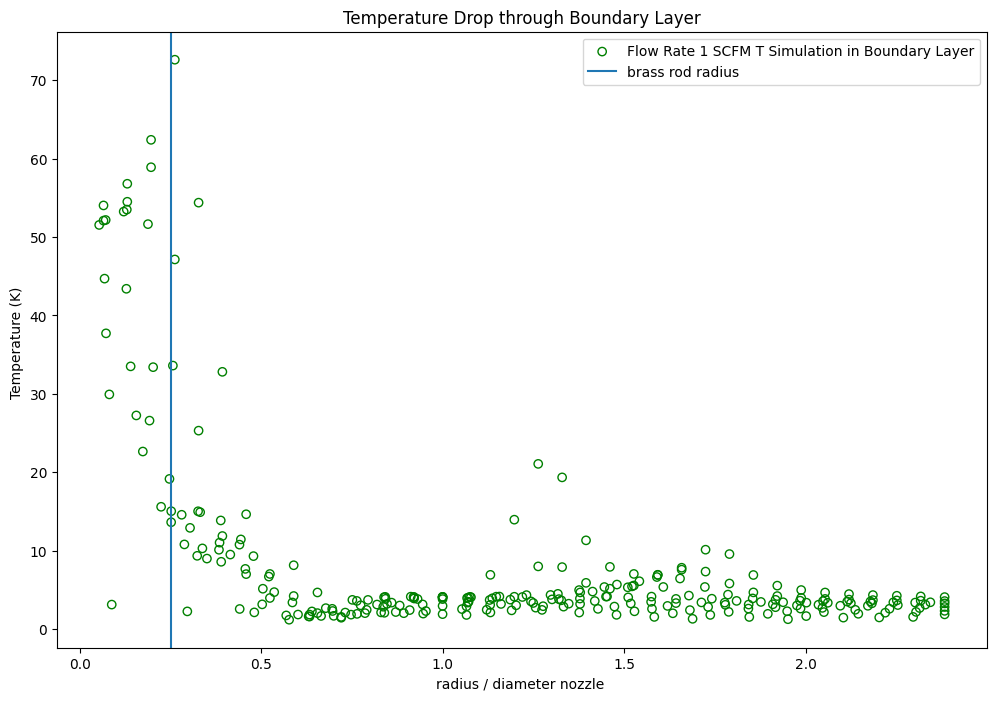

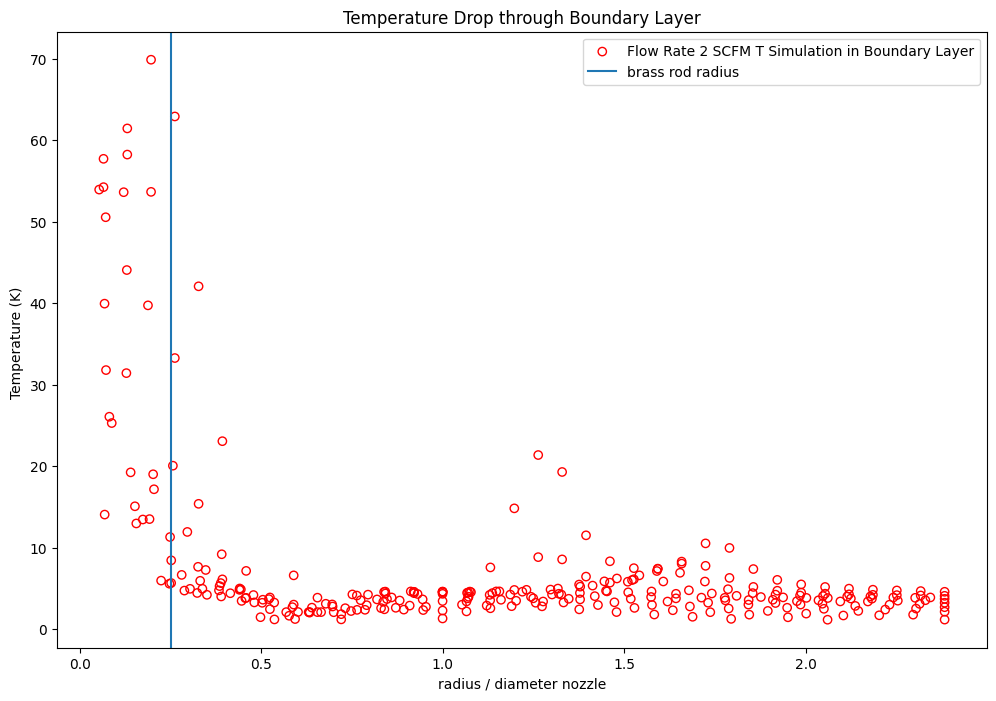

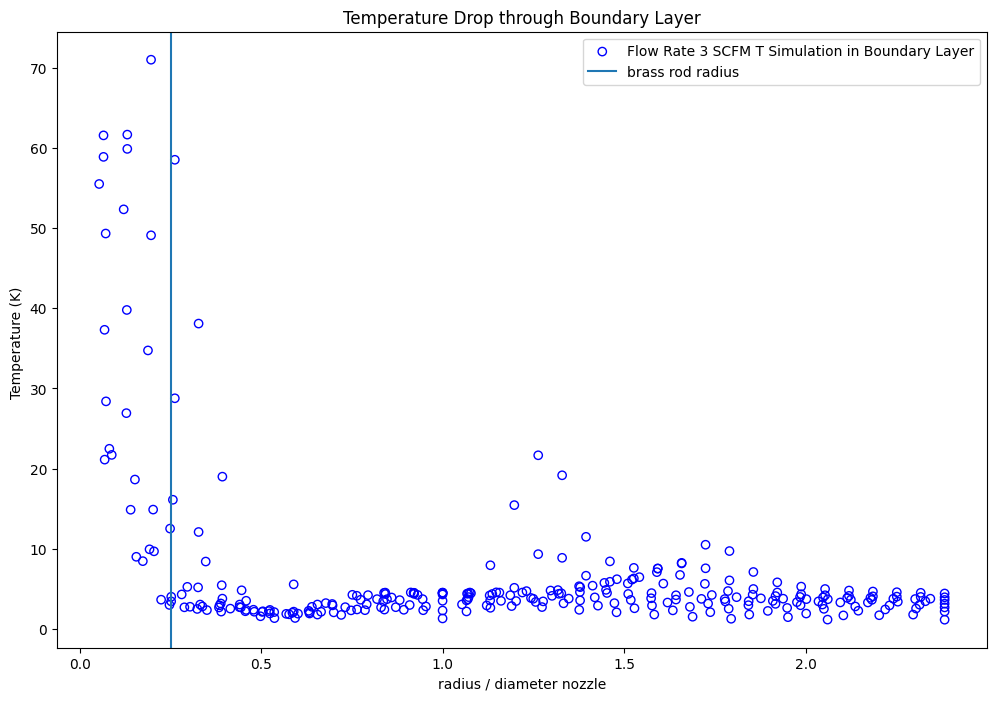

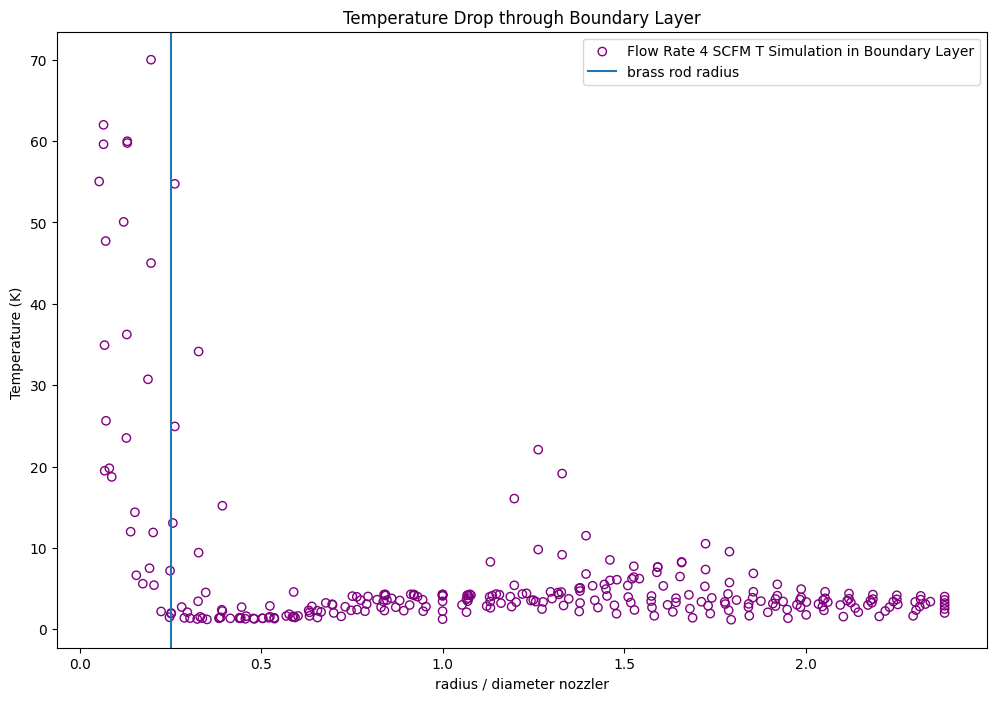

In [1604]:
plt.figure(figsize=(12, 8))
plt.scatter( BL_1['r/d'], BL_1['T_drop'], label = 'Flow Rate 1 SCFM T Simulation in Boundary Layer', edgecolors='g', facecolors='none')
plt.axvline(x=0.0125/(rod_diam*2), label="brass rod radius")
plt.xlabel("radius / diameter nozzle ")
plt.ylabel("Temperature (K) ")
plt.title("Temperature Drop through Boundary Layer")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(BL_2['r/d'], BL_2['T_drop'], label = 'Flow Rate 2 SCFM T Simulation in Boundary Layer', edgecolors='r', facecolors='none')
plt.axvline(x=0.0125/(rod_diam*2), label="brass rod radius")
plt.xlabel("radius / diameter nozzle")
plt.ylabel("Temperature (K) ")
plt.title("Temperature Drop through Boundary Layer")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(BL_3['r/d'], BL_3['T_drop'], label = 'Flow Rate 3 SCFM T Simulation in Boundary Layer', edgecolors='b', facecolors='none')
plt.axvline(x=0.0125/(rod_diam*2), label="brass rod radius")
plt.xlabel("radius / diameter nozzle")
plt.ylabel("Temperature (K) ")
plt.title("Temperature Drop through Boundary Layer")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(BL_4['r/d'], BL_4['T_drop'], label = 'Flow Rate 4 SCFM T Simulation in Boundary Layer', edgecolors='purple', facecolors='none')
plt.axvline(x=0.0125/(rod_diam*2), label="brass rod radius")
plt.xlabel("radius / diameter nozzler")
plt.ylabel("Temperature (K) ")
plt.title("Temperature Drop through Boundary Layer")
plt.legend()
plt.show()



We will use this expression from the stagnation point to compute BL thickness

$$
\frac{\delta_{0,R}}{D} = \left( \frac{1.95}{\text{Re}^{1/2}} \right) \left(1.04 - 0.034 \frac{H}{D} \right)^{-1/2}
\quad \quad
$$

In [1523]:
BL_thick_1 = (jet_rad*2) * (1.95/Reynolds_vals_1.iloc[0] ** (1/2)) * (1.04 - 0.034 * (.01/(jet_rad*2))) ** (-1/2)
BL_thick_2 = (jet_rad*2) * (1.95/Reynolds_vals_2.iloc[0] ** (1/2)) * (1.04 - 0.034 * (.01/(jet_rad*2))) ** (-1/2)
BL_thick_3 = (jet_rad*2) * (1.95/Reynolds_vals_3.iloc[0] ** (1/2)) * (1.04 - 0.034 * (.01/(jet_rad*2))) ** (-1/2)
BL_thick_4 = (jet_rad*2) * (1.95/Reynolds_vals_4.iloc[0] ** (1/2)) * (1.04 - 0.034 * (.01/(jet_rad*2))) ** (-1/2)

In [1603]:
BLs = [BL_thick_1, BL_thick_2, BL_thick_3, BL_thick_4]
print(velocities)

[np.float64(0.5934753579372897), np.float64(1.1869507158745793), np.float64(1.7804260738118691), np.float64(2.3739014317491587)]


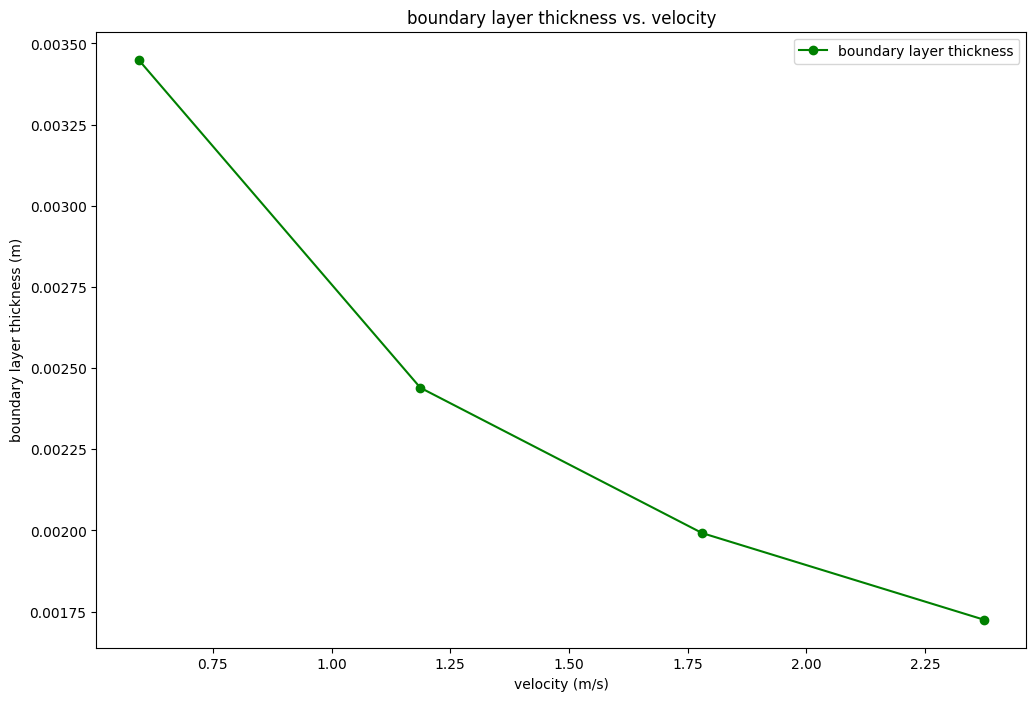

In [1525]:
plt.figure(figsize=(12, 8))
plt.plot(velocities, BLs, label="boundary layer thickness", marker = 'o', color = 'green')
plt.xlabel("velocity (m/s)")
plt.ylabel("boundary layer thickness (m)")
plt.title("boundary layer thickness vs. velocity")
plt.legend()

In [1599]:
h_stagnant = [k_air *10/ BL for BL in BLs]

In [1600]:
print(h_stagnant)

[np.float64(72.46636549326564), np.float64(102.48291689646192), np.float64(125.51542687419217), np.float64(144.93273098653128)]


In [1601]:
h_spatial

[29.1715, 37.3915, 46.554, 44.652]